## Import packages

In [2]:
# ——— Librerías estándar ———
import random
import math
from pathlib import Path

# ——— Análisis y manipulación de datos ———
import pandas as pd
import numpy as np

# ——— Datos geoespaciales ———
import geopandas as gpd
from shapely.geometry import Point

# ——— Grafos ———
import networkx as nx
import osmnx as ox

# ——— Optimización y rutas ———
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# ——— Visualización geoespacial ———
import folium
from folium import FeatureGroup, Icon, GeoJson, LayerControl

# ——— Visualización con gráficos ———
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

# ——— Escalado y clustering ———
from sklearn.preprocessing import RobustScaler
from sklearn_extra.cluster import KMedoids

# ——— Métricas de evaluación ———
from sklearn.metrics import silhouette_score

# ——— Progreso y paralelización ———
from tqdm.auto import tqdm  # para barras de progreso
import itertools


## Load data

In [3]:
def load_data(nombre_archivo, directorio_base='../../data/input'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"File not found: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' successfully loaded ({len(gdf)} records)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error loading '{nombre_archivo}': {str(e)}")
    
barrios = load_data('barris.geojson')
catastro = load_data('catastro.geojson')
puntos_carga = load_data('puntosCID.geojson')

✅ 'barris.geojson' successfully loaded (63 records)
✅ 'catastro.geojson' successfully loaded (36346 records)
✅ 'puntosCID.geojson' successfully loaded (882 records)


## General functions

In [4]:
def get_graph(request, seed=33):
    global barrio, G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos

    shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
    if len(shp_neighbourhood) != 1:
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
        if len(shp_neighbourhood) == 1:
            break
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]

    barrio = shp_neighbourhood["nombre"].values[0]
    shp_zone = shp_neighbourhood.geometry.values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(
        shp_zone,
        network_type="all_public",
        simplify=False,
        retain_all=False,
        truncate_by_edge=True
    )

    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']
    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street', 'primary_link', 'primary', 'tertiary', 'trunk', 'service', 'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    allowed_pedestrian = ['pedestrian', 'footway', 'path', 'track', 'bridleway', 'living_street', 'residential']

    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
                       if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()
    G_pedestrian = G.copy()

    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True)
                                if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)

    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True)
                                  if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    G_drive = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_walk = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()

    VELOCIDAD_PEATON=5
    VELOCIDAD_VEHICULO=35
    VELOCIDAD_CONEXION=10

    """
    Construye el supergrafo uniendo G_drive y G_walk, añade nodos especiales
    y calcula tiempos de viaje con velocidades muestreadas de distribuciones
    normales. El parámetro `seed` hace que las muestras aleatorias sean reproducibles.
    """

    # Crea el RNG reproducible
    rng = np.random.RandomState(seed)

    # 1) Crear supergrafo vacío
    G_super = nx.MultiDiGraph()
    G_super.add_nodes_from(G_drive.nodes(data=True))
    G_super.add_nodes_from(G_walk.nodes(data=True))

    # 2) Función para fusionar aristas
    def add_or_merge_edge(G, u, v, key, data, mode):
        data = data.copy()
        modos = data.get('mode', [])
        if not isinstance(modos, list):
            modos = [modos]
        if mode not in modos:
            modos.append(mode)
        data['mode'] = modos

        if G.has_edge(u, v):
            for k_exist, existing in G[u][v].items():
                if existing.get('geometry') == data.get('geometry'):
                    exist_mod = existing.get('mode', [])
                    if not isinstance(exist_mod, list):
                        exist_mod = [exist_mod]
                    for m in modos:
                        if m not in exist_mod:
                            exist_mod.append(m)
                    existing['mode'] = exist_mod
                    return
        G.add_edge(u, v, key=key, **data)

    # Añadir aristas de conducción
    for u, v, k, data in G_drive.edges(keys=True, data=True):
        add_or_merge_edge(G_super, u, v, k, data, 'drive')
        if not data.get('oneway', True) or data.get('reversed', False):
            add_or_merge_edge(G_super, v, u, k, data, 'drive')
        elif not G_drive.has_edge(v, u):
            fake_data = data.copy()
            fake_data['fake'] = True
            dist = fake_data.get('length', 100)
            fake_data['length'] = dist * 5
            add_or_merge_edge(G_super, v, u, k, fake_data, 'drive')

    # Añadir aristas de paseo
    for u, v, k, data in G_walk.edges(keys=True, data=True):
        add_or_merge_edge(G_super, u, v, k, data, 'walk')
        if not G_walk.has_edge(v, u):
            add_or_merge_edge(G_super, v, u, k, data, 'walk')

    # 3) Haversine helper
    def haversine(coord1, coord2):
        lon1, lat1, lon2, lat2 = map(math.radians, [*coord1, *coord2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        return 2 * math.asin(math.sqrt(a)) * 6371000

    # 4) Función para añadir nodo especial
    def add_special_node(G, geom, tipo, idx):
        nid = f"{tipo}_{idx}"
        lon, lat = geom.centroid.x, geom.centroid.y
        G.add_node(nid, x=lon, y=lat, tipo=tipo)

        conexiones = []
        if tipo in ['carga', 'almacen']:
            nd = ox.distance.nearest_nodes(G_drive, lon, lat)
            conexiones.append((nd, 'drive',
                                haversine((lon, lat),
                                          (G_drive.nodes[nd]['x'], G_drive.nodes[nd]['y']))))
            nw = ox.distance.nearest_nodes(G_walk, lon, lat)
            conexiones.append((nw, 'walk',
                                haversine((lon, lat),
                                          (G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']))))
        else:
            nw = ox.distance.nearest_nodes(G_walk, lon, lat)
            conexiones.append((nw, 'walk',
                                haversine((lon, lat),
                                          (G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']))))

        for vec, modo, dist in conexiones:
            G.add_edge(nid, vec, mode=['connection', modo], length=dist)
            G.add_edge(vec, nid, mode=['connection', modo], length=dist)

        return nid

    nodos_carga = [
        add_special_node(G_super, row.geometry, 'carga', i)
        for i, row in shp_loading_points.iterrows()
    ]
    nodos_comercios = [
        add_special_node(G_super, row.geometry, 'comercio', i)
        for i, row in shp_bajos[shp_bajos['Comercio']].iterrows()
    ]
    nodos_almacenes = [
        add_special_node(G_super, row.geometry, 'almacen', i)
        for i, row in shp_bajos[shp_bajos['Almacen']].iterrows()
    ]

    # 5) Añadir tiempos a aristas
    def calcular_tiempos_en_aristas(G, v_w, v_v, v_c, rng):
        def tpd(dist, vel):
            return dist / (vel * 1000 / 60)

        # Muestras con el RNG local
        v_peat = rng.normal(v_w, 0.2 * v_w, 30)
        v_conn = rng.normal(v_c, 0.2 * v_c, 30)
        v_veh  = rng.normal(v_v, 0.2 * v_v, 30)

        for u, v, k, data in G.edges(keys=True, data=True):
            d = data.get('length', 100)
            modos = data.get('mode', [])

            if 'connection' in modos:
                data['tiempo_walk']  = tpd(d, rng.choice(v_peat))
                data['tiempo_drive'] = tpd(d, rng.choice(v_conn))
                continue

            if 'walk' in modos:
                data['tiempo_walk'] = tpd(d, rng.choice(v_peat))

            if 'drive' in modos:
                vmax = data.get('maxspeed', rng.choice(v_veh))
                if isinstance(vmax, str):
                    vmax = int(''.join(filter(str.isdigit, vmax)) or 30)
                vkh = max(vmax * 0.5, rng.normal(vmax * 0.8, vmax * 0.1))
                data['tiempo_drive'] = tpd(d, vkh)

            # Asegurar que existe la clave
            data.setdefault('tiempo_walk', float('inf'))
            data.setdefault('tiempo_drive', float('inf'))

    calcular_tiempos_en_aristas(G_super,
                                VELOCIDAD_PEATON,
                                VELOCIDAD_VEHICULO,
                                VELOCIDAD_CONEXION,
                                rng)

    print(f"✅ Supergraph {barrio} created: {len(G_super.nodes)} nodes, {len(G_super.edges)} edges.")
    return G_super, nodos_carga, nodos_comercios, nodos_almacenes

def calcular_tiempo_walk(G, origen, destino):
    """Ruta más rápida a pie entre origen y destino (minutos), usando el grafo G."""
    try:
        camino = nx.shortest_path(G, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed = G.get_edge_data(u, v)
        t_min = min(e['tiempo_walk'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

def calcular_tiempo_drive(G, origen, destino):
    """Ruta más rápida en vehículo entre origen y destino (minutos), usando el grafo G."""
    try:
        camino = nx.shortest_path(G, origen, destino, weight='tiempo_drive')
    except nx.NetworkXNoPath:
        return float('inf'), []
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed = G.get_edge_data(u, v)
        tiempo += min(e.get('tiempo_drive', math.inf) for e in ed.values())
    return tiempo, camino

def generate_context(nodos_comercios,
                     N_PAQUETES=100,
                     PAQUETES_MIN=1,
                     PAQUETES_MAX=5,
                     CAPACIDAD_MAXIMA=8,
                     FACTOR_AJUSTE=0.75,
                     seed=None):
    """
    Selecciona comercios aleatorios y reparte paquetes sobre ellos de forma eficiente,
    eliminando del muestreo aquellos nodos que no puedan recibir la cantidad mínima de paquetes.

    Args:
      nodos_comercios (list): lista de IDs de nodo “comercio” en G_super (variable global).
      N_PAQUETES      (int): total de paquetes a repartir.
      PAQUETES_MIN    (int): mínimo paquetes por comercio.
      PAQUETES_MAX    (int): máximo paquetes por comercio.
      CAPACIDAD_MAXIMA(int): capacidad máxima que un nodo puede recibir.
      FACTOR_AJUSTE   (float): factor para ajustar N_PAQUETES cuando se acerca al límite de capacidad.

    Devuelve:
      n_paq (int): número final de paquetes asignados.
      GeoDataFrame con columnas ['node', 'paquetes', 'geometry'].
      entrada (str): nodo de entrada para el repartidor.
    """

    # Instanciamos un RNG local
    rng = np.random.RandomState(seed)
    
    
    # Validación de parámetros
    if (PAQUETES_MAX < PAQUETES_MIN or PAQUETES_MIN < 0 or 
        PAQUETES_MAX < 0 or CAPACIDAD_MAXIMA < 0 or 
        CAPACIDAD_MAXIMA < min(PAQUETES_MIN, PAQUETES_MAX)):
        raise ValueError("Invalid values for constants. Check the input values.")
    
    n_comercios = len(nodos_comercios)
    max_paquetes = n_comercios * CAPACIDAD_MAXIMA
    proporcion = N_PAQUETES / max_paquetes
    
    # Ajuste preliminar de N_PAQUETES si la proporción es alta
    if proporcion >= FACTOR_AJUSTE:
        N_PAQUETES = int(max_paquetes * FACTOR_AJUSTE)
    
    # Inicializar capacidades y lista de nodos disponibles
    capacidades = {nodo: CAPACIDAD_MAXIMA for nodo in nodos_comercios}
    available_nodes = nodos_comercios.copy()  # lista mutable de nodos disponibles

    # Listas para almacenar asignaciones
    seleccionados = []
    paquetes_asignados_list = []
    
    paquetes_asignados = 0
    n_paq = N_PAQUETES

    # Bucle principal: mientras haya paquetes por asignar y nodos disponibles
    while paquetes_asignados < N_PAQUETES and available_nodes:
        restante = N_PAQUETES - paquetes_asignados
        max_pos = min(PAQUETES_MAX, restante)
        if max_pos < PAQUETES_MIN:
            break

        # Selección aleatoria eficiente: 
        idx = available_nodes.index(rng.choice(available_nodes))
        nodo = available_nodes[idx]
        cap_restante = capacidades[nodo]

        # Si el nodo no tiene capacidad para PAQUETES_MIN, se elimina de la lista
        if cap_restante < PAQUETES_MIN:
            available_nodes[idx] = available_nodes[-1]
            available_nodes.pop()
            continue

        # Determinar la cantidad de paquetes a asignar
        paquetes_a_asignar = rng.randint(PAQUETES_MIN, min(max_pos, cap_restante)+1)
        
        # Registrar la asignación
        seleccionados.append(nodo)
        paquetes_asignados_list.append(paquetes_a_asignar)
        
        capacidades[nodo] -= paquetes_a_asignar
        paquetes_asignados += paquetes_a_asignar

        # Si tras la asignación la capacidad es insuficiente, se elimina el nodo de la lista
        if capacidades[nodo] < PAQUETES_MIN:
            available_nodes[idx] = available_nodes[-1]
            available_nodes.pop()
    
    # Agrupar las asignaciones por nodo
    asignacion_por_nodo = {}
    for nodo, paquetes in zip(seleccionados, paquetes_asignados_list):
        asignacion_por_nodo[nodo] = asignacion_por_nodo.get(nodo, 0) + paquetes

    # Construir la lista de datos para el GeoDataFrame usando la variable global G_super para obtener coordenadas
    data = []
    for nodo, total in asignacion_por_nodo.items():
        lon = G_super.nodes[nodo]['x']
        lat = G_super.nodes[nodo]['y']
        data.append({
            'node': nodo,
            'paquetes': total,
            'geometry': Point(lon, lat)
        })

    # Elegir punto de entrada
    thresh, thresh_max = 0.0001, 0.1
    entrada = None
    while entrada is None:
        boundary = [n for n, d in G_super.nodes(data=True)
                    if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh and 'tipo' not in data ]
        if len(boundary) < 5:
            thresh = min(thresh * 3, thresh_max)
            if thresh >= thresh_max:
                raise RuntimeError("No hay nodos periféricos válidos.")
            continue

        rng.shuffle(boundary)
        for b in boundary: 
            random_cid = rng.choice(nodos_carga)
            try:
                t, _ = calcular_tiempo_drive(G_super, b, random_cid) # para asegura que esta en drive
                if t < 1000:
                    entrada = b
                    break
            except nx.NetworkXNoPath:
               continue
        thresh = min(thresh * 3, thresh_max)

    return n_paq, gpd.GeoDataFrame(data, crs="EPSG:4326"), entrada

## M1 (VAN MODEL)

In [5]:
def simulation_M1(df_comercios, nodo_entrada, nodos_carga, CAPACIDAD_MAXIMA=8):
    ########
    # 1º
    ########
    def cid_assigment(df_comercios, nodos_carga, CAPACIDAD_MAXIMA = CAPACIDAD_MAXIMA, extra_penalty=0.1):
        """
        Heurística Marginal Trips.

        Args:
        df_comercios     : GeoDataFrame con ['node','paquetes','geometry'].
        nodos_carga      : lista de nodos CID.
        CAPACIDAD_MAXIMA : capacidad máxima de carga del repartidor.
        extra_penalty    : factor multiplicativo para penalizar viajes extra.

        Devuelve:
        assign_df : DataFrame con ['commerce_id','paquetes','assigned_cid',
                                    'walk_time_min','delta_runs'].
        loads_df  : GeoDataFrame con ['node','geometry','total_load','required_runs'].
        """
        # Construir df_cid
        df_cid = gpd.GeoDataFrame(
            {'node': nodos_carga},
            geometry=[Point(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in nodos_carga],
            crs=df_comercios.crs
        )

        # 1) Matriz de tiempos a pie
        n, m = len(df_comercios), len(df_cid)
        time_walk = np.zeros((n, m))
        for i, ci in df_comercios.iterrows():
            for j, sj in df_cid.iterrows():
                t, _ = calcular_tiempo_walk(G_super, sj['node'], ci['node'])  
                time_walk[i, j] = t

        # 2) Asignación Marginal Trips
        L = np.zeros(m, dtype=int)
        assignments = []
        for i, ci in df_comercios.iterrows():
            best_cost, best_j = float('inf'), None
            for j, sj in df_cid.iterrows():
                runs_before = math.ceil(L[j] / CAPACIDAD_MAXIMA)
                runs_after  = math.ceil((L[j] + ci['paquetes']) / CAPACIDAD_MAXIMA)
                delta_runs  = runs_after - runs_before
                cost = time_walk[i, j] + time_walk[i, j] * delta_runs * extra_penalty
                if cost < best_cost:
                    delta_f = delta_runs
                    best_cost, best_j = cost, j

            assignments.append({
                'commerce_id':  ci['node'],
                'paquetes':     ci['paquetes'],
                'assigned_cid': df_cid.loc[best_j, 'node'],
                'walk_time_min': time_walk[i, best_j],
                'delta_runs':    delta_f
            })
            L[best_j] += ci['paquetes']

        assign_df = pd.DataFrame(assignments)

        # 3) Cargas y viajes requeridos
        loads_df = gpd.GeoDataFrame({
            'node':        df_cid['node'],
            'geometry':    df_cid['geometry'],
            'total_load':  L,
            'required_runs': np.ceil(L / CAPACIDAD_MAXIMA).astype(int)
        }, crs=df_cid.crs)

        return assign_df, loads_df

    
    assign_df, loads_df = cid_assigment(df_comercios,
                                        nodos_carga, 
                                        CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA,
                                        extra_penalty=0.05
                                    )

    ########
    # 2º
    ########

    def walk_routes(assign_df, loads_df, CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA):
        """
        CVRP con OR-Tools, tiempos en segundos, manejo de 'inf'
        y cómputo de distancia recorrida por ruta.

        Args:
        assign_df          : DataFrame con ['commerce_id','paquetes','assigned_cid'].
        loads_df           : GeoDataFrame con ['node',...].
        capacidad_maxima   : int, Q paquetes por ruta.

        Returns:
        routes_df : DataFrame ['cid','batch','sequence','time_min','distance_km','load'].
        """
        all_routes = []
        total_time_sec = 0
        total_batches = 0
        INF_SEC = 10**9

        for _, row in loads_df.iterrows():
            cid = row['node']
            assigned = assign_df[assign_df['assigned_cid'] == cid]
            if assigned.empty:
                continue

            # 1) nodos y demandas
            locations = [cid] + assigned['commerce_id'].tolist()
            demands   = [0]   + assigned['paquetes'].tolist()
            N = len(locations)

            # 2) matriz de tiempos (segundos)
            time_matrix = [[0]*N for _ in range(N)]
            for i in range(N):
                for j in range(N):
                    if i == j: continue
                    try:
                        t_min, _ = calcular_tiempo_walk(G_super, locations[i], locations[j])  # Intentamos con G_super
                    except Exception:
                        t_min = INF_SEC
                    time_matrix[i][j] = INF_SEC if not np.isfinite(t_min) else int(math.ceil(t_min*60))

            # 3) número de rutas necesarias
            total_demand = sum(demands)
            R = math.ceil(total_demand / CAPACIDAD_MAXIMA)

            # 4) configurar OR-Tools
            manager = pywrapcp.RoutingIndexManager(N, R, 0)
            routing = pywrapcp.RoutingModel(manager)

            def time_callback(f, t):
                return time_matrix[manager.IndexToNode(f)][manager.IndexToNode(t)]
            cb_t = routing.RegisterTransitCallback(time_callback)
            routing.SetArcCostEvaluatorOfAllVehicles(cb_t)

            def demand_callback(idx):
                return demands[manager.IndexToNode(idx)]
            cb_d = routing.RegisterUnaryTransitCallback(demand_callback)
            routing.AddDimensionWithVehicleCapacity(cb_d, 0, [CAPACIDAD_MAXIMA+1]*R, True, "Capacity")

            search_params = pywrapcp.DefaultRoutingSearchParameters()
            search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
            search_params.time_limit.seconds = 3

            try:
                sol = routing.SolveWithParameters(search_params)
                if not sol:
                    raise RuntimeError(f"No solution CVRP for CID {cid}")
            except RuntimeError:
                (f"No solution CVRP for CID {cid}")
                continue
            # 5) extraer rutas y calcular distancia
            for v in range(R):
                idx = routing.Start(v)
                if routing.IsEnd(sol.Value(routing.NextVar(idx))):
                    continue
                seq_nodes = []
                load = 0
                time_sec = 0
                dist_m = 0.0
                # construir ruta
                while not routing.IsEnd(idx):
                    n = manager.IndexToNode(idx)
                    seq_nodes.append(locations[n])
                    load += demands[n]
                    nxt = sol.Value(routing.NextVar(idx))
                    time_sec += routing.GetArcCostForVehicle(idx, nxt, v)

                    # distancia tramo a tramo
                    a, b = locations[n], locations[manager.IndexToNode(nxt)]
                    _, path = calcular_tiempo_walk(G_super, a, b)  # Usamos G_super para la distancia
                    if path:
                        for u, w in zip(path[:-1], path[1:]):
                            ed = G_super.get_edge_data(u, w)
                            dist_m += min(e.get('length', 0) for e in ed.values())

                    idx = nxt

                # retorno opcional al depósito
                seq_nodes.append(cid)

                all_routes.append({
                    'cid':         cid,
                    'travel_number':       v+1,
                    'sequence':    seq_nodes,
                    'time_min':    round(time_sec/60, 3),
                    'distance_km': round(dist_m/1000, 3),
                    'load':        load
                })
                total_time_sec += time_sec
                total_batches += 1

        routes_df = pd.DataFrame(all_routes)
        return routes_df


    routes_df = walk_routes(
        assign_df,
        loads_df, 
        CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA
    )

    ########
    # 3º
    ########

    def drive_route(routes_df, nodo_entrada):
        """
        Calcula el recorrido óptimo que pasa por todos los CIDs únicos en routes_df,
        utilizando el grafo de conducción G_super y la función calcular_tiempo_drive.
        
        Args:
        routes_df    : DataFrame con ['cid', 'travel_number', 'sequence', ...] que contiene las rutas.  
        nodo_entrada : nodo por donde llega la furgoneta  
        Returns:
        cid_route    : DataFrame con las rutas entre los CIDs, tiempos y distancias calculados.
        """
            

        unique_cids = routes_df['cid'].unique()
        N = len(unique_cids) + 1  # +1 porque también contamos con el nodo de depósito
        time_matrix = [[0] * N for _ in range(N)]
        
        # Llenamos la matriz de tiempos entre todos los CIDs y el depósito
        cid_to_index = {cid: idx + 1 for idx, cid in enumerate(unique_cids)}
        cid_to_index['deposit'] = 0  # El nodo del depósito estará en la posición 0
        
        # Rellenar la matriz con los tiempos de conducción
        for i, cid1 in enumerate([nodo_entrada] + list(unique_cids)):
            for j, cid2 in enumerate([nodo_entrada] + list(unique_cids)):
                if i != j:
                    # Calculamos el tiempo de conducción entre los CIDs
                    try:
                        t_min, _ = calcular_tiempo_drive(G_super, cid1, cid2)
                    except Exception:
                        t_min = float('inf')  # Si hay un error, asignamos un valor infinito
                    if np.isfinite(t_min):
                        time_matrix[i][j] = int(math.ceil(t_min * 60))  # Convertimos minutos a segundos
        
        # 4) Resolver el TSP con OR-Tools
        manager = pywrapcp.RoutingIndexManager(N, 1, 0)  # 1 vehículo, comenzamos desde el nodo 0 (depósito)
        routing = pywrapcp.RoutingModel(manager)

        def time_callback(from_index, to_index):
            # Llamada a la función para obtener el tiempo entre dos nodos
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return time_matrix[from_node][to_node]

        transit_callback_index = routing.RegisterTransitCallback(time_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Parámetros de búsqueda
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
        search_parameters.time_limit.seconds = 3  # Limitar el tiempo de búsqueda

        # Resolvemos el problema de TSP
        solution = routing.SolveWithParameters(search_parameters)
        if not solution:
            raise RuntimeError("No se pudo encontrar una solución para el TSP")

        # 5) Extraer la ruta óptima y calcular la distancia total
        route_sequence = [nodo_entrada]  # Iniciamos con el nodo de depósito
        total_time_sec = 0
        total_distance_m = 0
        idx = routing.Start(0)
        
        while not routing.IsEnd(idx):
            node_index = manager.IndexToNode(idx)
            cid = list(unique_cids)[node_index - 1]  # Obtener el CID correspondiente
            route_sequence.append(cid)  # Agregar CID correspondiente
            next_idx = solution.Value(routing.NextVar(idx))
            total_time_sec += routing.GetArcCostForVehicle(idx, next_idx, 0)

            # Calculamos la distancia entre los nodos
            a, b = route_sequence[-2], route_sequence[-1]  # Usamos los últimos dos CIDs
            _, path = calcular_tiempo_drive(G_super, a, b)
            if path:
                for u, w in zip(path[:-1], path[1:]):
                    ed = G_super.get_edge_data(u, w)
                    total_distance_m += min(e.get('length', 0) for e in ed.values())

            idx = next_idx

        # Añadimos el nodo de vuelta al inicio para cerrar la ruta

        total_time_min = round(total_time_sec / 60, 3)
        total_distance_km = round(total_distance_m / 1000, 3)

        # 6) Crear el DataFrame con la ruta calculada
        cid_route = {
            'deposito': nodo_entrada,
            'sequence': [[nodo_entrada] + route_sequence],  # Aquí se crea la lista de la columna 'cid'
            'time_min': total_time_min,
            'distance_km': total_distance_km
        }

        return cid_route

    cid_route = drive_route(
        routes_df, nodo_entrada)  
    

    ########
    # 4º
    ########

    def calculate_results_m1(routes_df, cid_route):
        """
        Calcula el coste total del reparto sumando costes fijos, por tiempo y por distancia.
        
        Args:
            routes_df    : rutas andando
            cid_route    : ruta furgone
        
        Returns:
            total_cost   : Diccionario con los costes calculados.
        """
            # Definición de las constantes fuera de la función
        FIXED_DAILY_RATE_VAN      = 31.76   # €/día 
        TIME_HOURLY_RATE_VAN      = 21.19 + FIXED_DAILY_RATE_VAN / 8  # €/hora
        DISTANCE_PER_KM_RATE_VAN  = 0.184   # €/km

        total_kms_walk = routes_df['distance_km'].sum() 
        total_hours_walk = routes_df['time_min'].sum() / 60
        total_kms_drive = cid_route['distance_km']
        total_hours_drive = cid_route['time_min'] / 60

        distance_cost_van = total_kms_drive * DISTANCE_PER_KM_RATE_VAN 
        distance_cost_ona = 0
        time_cost_van = (total_hours_drive + total_hours_walk) * TIME_HOURLY_RATE_VAN
        time_cost_ona = 0

        results = {
            'total_kms_walk': total_kms_walk,
            'total_hours_walk': total_hours_walk,
            'total_kms_drive': total_kms_drive,
            'total_hours_drive': total_hours_drive,
            'distance_cost_van': distance_cost_van,
            'distance_cost_ona': distance_cost_ona,
            'time_cost_van': time_cost_van,
            'time_cost_ona': time_cost_ona,
            'total_cost': distance_cost_van + time_cost_van + distance_cost_ona + time_cost_ona
        }
    
        return {categoria: round(valor, 4)  for categoria, valor in results.items()}

    


    return calculate_results_m1(routes_df, cid_route)


## Simulation M2

In [ ]:
def simulation_M2(df_comercios, nodo_entrada, nodos_almacenes, seed=None, CAPACIDAD_MAXIMA_ONA=20):
    ########
    # 1º
    ########
    def planificar_hub(nodo_entrada, nodos_almacenes,  percentil=50, seed=seed):
        """
        Selecciona un hub de almacén cercano al centroide del grafo y calcula la ruta
        desde un nodo de entrada hasta ese hub. Si el hub elegido falla, reintenta con
        los demás candidatos.

        Parámetros:
        - nodo_entrada: Nodo inicial (depósito periférico) desde el que partimos.
        - nodos_almacenes: Lista de nodos de almacenes.
        - percentil: Percentil de almacenes más cercanos al centroide a considerar (por defecto 50).
        - seed: Semilla para la aleatoriedad (opcional).

        Retorna:
        - dict con:
            'depot'   : nodo_entrada,
            'hub'     : nodo seleccionado con ruta válida,
            't_drive' : tiempo de conducción al hub (en minutos),
            'dist'    : distancia total (en km),
            'camino'  : lista de nodos que forman la ruta
        o None si ningún candidato tiene ruta.
        """
        # Instanciamos un RNG local
        rng = np.random.RandomState(seed)

        # 1. Calcular el centroide usando todos los almacenes
        xs = [G_super.nodes[n]['x'] for n in nodos_almacenes]
        ys = [G_super.nodes[n]['y'] for n in nodos_almacenes]
        centroide = Point(np.mean(xs), np.mean(ys))

        # 2. Medir distancia euclídea de cada almacén al centroide
        distancias = [
            (n, centroide.distance(Point(G_super.nodes[n]['x'],
                                        G_super.nodes[n]['y'])))
            for n in nodos_almacenes
        ]

        # 3. Obtener los N más cercanos según el percentil
        num_cand = math.ceil(len(distancias) * (percentil / 100))
        candidatos = sorted(distancias, key=lambda x: x[1])[:num_cand]
        almacenes_cercanos = [n for n, _ in candidatos]

        # 4. Intentar cada hub en orden aleatorio hasta encontrar ruta válida
        for hub in rng.choice(almacenes_cercanos,size=len(almacenes_cercanos),
        replace=False):
            try:
                t_drive, camino = calcular_tiempo_drive(G_super, nodo_entrada, hub)
                if np.isfinite(t_drive):
                    distancia_m = sum(
                        G_super.get_edge_data(u, v)[0]['length']
                        for u, v in zip(camino[:-1], camino[1:])
                    )
                    return {
                        'depot': nodo_entrada,
                        'hub': hub,
                        't_drive': t_drive,
                        'dist': distancia_m / 1000,
                        'camino': camino
                    }
            except nx.NetworkXNoPath:
                # Este hub no conecta, pasamos al siguiente candidato
                continue

        # Si agotamos todos los candidatos sin éxito:
        print(f"❌ Ningún hub de los {len(almacenes_cercanos)} candidatos tuvo ruta válida.")
        return None

    hub_route = planificar_hub(nodo_entrada, nodos_almacenes, percentil=50, seed=seed)

    ########
    # 2º
    ########

    K_MIN   = 2
    K_MAX   = 10
    ALPHA   = 0.25  # peso Silhouette
    BETA    = 0.25  # peso Inertia
    GAMMA   = 0.5  # peso Balance de capacidad

    def clustering(df_comercios, hub_route, cap_max=CAPACIDAD_MAXIMA_ONA, k_min=2, k_max=10, alpha=0.2, beta=0.2, gamma=0.6, seed = seed, view=False):
        """
        Clustering de los comercios usando K-Medoids, evaluando el mejor número de clústeres con el
        método combinado de Silhouette, Inertia, y Balance de Capacidad, con ponderaciones.

        Args:
        df_comercios    : DataFrame con ['node', 'paquetes', 'geometry', 'grupo_repartidor'].
        hub_route           : Info del hub, para calcular la distancia de balance de capacidad.
        cap_max         : Capacidad máxima de la ruta para el balance.
        k_min           : Número mínimo de clústeres.
        k_max           : Número máximo de clústeres.
        alpha           : Peso del índice Silhouette.
        beta            : Peso de la Inertia.
        gamma           : Peso del balance de capacidad.
        seed            : Semilla para la aleatoriedad (opcional).

        Returns:
        best_k          : El mejor número de clústeres encontrado.
        """

        # 1) Extraemos las coordenadas y demandas
        coords = np.vstack([df_comercios.geometry.x.values, df_comercios.geometry.y.values]).T
        hub = hub_route['hub']
        hub_coord = (G_super.nodes[hub]['x'], G_super.nodes[hub]['y'])
        demands = df_comercios['paquetes'].to_numpy()

        ks, sils, ines, balances = [], [], [], []
        hub_x, hub_y = hub_coord

        for k in range(k_min, min(k_max + 1, len(df_comercios))):
            # 2) Entrenamos K-Medoids
            kmed = KMedoids(n_clusters=k, init='k-medoids++', method='pam', metric='euclidean', random_state=seed)
            labels = kmed.fit_predict(coords)

            # 3) Calculamos el índice de Silhouette
            sil = silhouette_score(coords, labels) if k > 1 else 0

            # 4) Calculamos la Inertia manualmente usando las posiciones de los medoids
            medoids = coords[kmed.medoid_indices_]
            inertia = sum(np.sum((coords[labels == j] - medoids[j]) ** 2) for j in range(k))

            # 5) Balance de capacidad
            loads = np.array([demands[labels == j].sum() for j in range(k)])
            mults = np.ceil(loads / cap_max) * cap_max
            errors = (loads - mults) ** 2
            bal = np.mean(errors)

            ks.append(k)
            sils.append(sil)
            ines.append(inertia)
            balances.append(bal)

        # 6) Escalado robusto de las métricas
        scaler = RobustScaler()
        sil_r = scaler.fit_transform(np.array(sils).reshape(-1, 1)).ravel()
        ine_r = -scaler.fit_transform(np.array(ines).reshape(-1, 1)).ravel()
        bal_r = -scaler.fit_transform(np.array(balances).reshape(-1, 1)).ravel()

        # 7) Combinamos las métricas con penalización por número de clústeres
        combined = alpha * sil_r + beta * ine_r + gamma * bal_r
        best_idx = np.argmax(combined)
        best_k = ks[best_idx]

        if view:
            # 8) Visualización del diagnóstico
            fig, ax = plt.subplots(figsize=(15, 10))
            ax.plot(ks, sil_r, marker='o', label='Silhouette')
            ax.plot(ks, ine_r, marker='s', label='– Inertia')
            ax.plot(ks, bal_r, marker='d', label='– Capacity Balance')
            ax.plot(ks, combined, marker='^', lw=2, color='black', label='Combined')
            ax.axvline(best_k, ls='--', color='gray', label=f'Best k = {best_k}')
            ax.set(xlabel='k', ylabel='Score', title='k selection with K-Medoids + RobustScaler')
            ax.legend()
            plt.tight_layout()
            plt.show()

        # 9) Clustering final con el mejor k encontrado
        kmed = KMedoids(n_clusters=best_k, init='k-medoids++', method='pam', metric='euclidean', random_state=seed)
        labels = kmed.fit_predict(coords)
        df_comercios['grupo_repartidor'] = labels + 1  
        
        return best_k, df_comercios

    # Ejemplo de uso
    best_k, df_comercios = clustering(df_comercios, hub_route, CAPACIDAD_MAXIMA_ONA, view=False)

    ########
    # 3º
    ########   

    def cluster_routes(df_comercios, hub_route, CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA_ONA):
        """
        Calcular rutas de entrega para cada grupo de repartidor usando CVRP con OR-Tools,
        tiempos en segundos, manejo de 'inf' y cómputo de distancia recorrida por ruta.
        
        Args:
        df_comercios     : DataFrame con ['node', 'paquetes', 'geometry', 'grupo_repartidor'].
        capacidad_maxima : int, capacidad máxima de paquetes por ruta.
        
        Returns:
        routes_df        : DataFrame con rutas por cada grupo de repartidor ['grupo_repartidor', 'sequence', 'time_min', 'distance_km', 'load'].
        """
        
        all_routes = []
        total_time_sec = 0
        total_batches = 0
        INF_SEC = 10**9  # Valor para distancias infinitas (cuando no hay conexión)
        
        # Agrupar comercios por 'grupo_repartidor'
        grupos_repartidor = df_comercios['grupo_repartidor'].unique()
        
        # Iteramos sobre cada grupo de repartidor
        for grupo_sel in grupos_repartidor:
            # Filtrar comercios de ese grupo
            sub_bajos = df_comercios[df_comercios['grupo_repartidor'] == grupo_sel]
            N = len(sub_bajos) + 1
            
            # Si no hay comercios para este grupo, continuar con el siguiente
            if N == 0:
                continue
            
            # 1) Nodos y demandas (los comercios dentro del grupo + el hub)
            hub = hub_route['hub']  # El nodo del hub
            locations = list(sub_bajos['node'])  # Los nodos de comercios
            locations.insert(0, hub)  # Añadir el hub como punto de inicio
            demands = list(sub_bajos['paquetes'])  # Demandas de paquetes
            demands.insert(0, 0)  # El hub tiene demanda cero
            
            # 2) Matriz de tiempos (segundos) entre los comercios
            time_matrix = [[0]*N for _ in range(N)]
            for i in range(N):
                for j in range(N):
                    if i == j:
                        continue
                    try:
                        t_min, _ = calcular_tiempo_walk(G_super, locations[i], locations[j])  # Intentamos con G_super
                    except Exception:
                        t_min = INF_SEC  # Si no hay ruta, marcarlo como "infinito"
                    time_matrix[i][j] = INF_SEC if not np.isfinite(t_min) else int(math.ceil(t_min * 60))  # Convertir a minutos
            
            # 3) Número de rutas necesarias
            total_demand = sum(demands)
            R = math.ceil(total_demand / CAPACIDAD_MAXIMA)  # El número de rutas necesarias
            
            # 4) Configurar OR-Tools para el problema de CVRP
            manager = pywrapcp.RoutingIndexManager(N, R, 0)
            routing = pywrapcp.RoutingModel(manager)

            def time_callback(f, t):
                return time_matrix[manager.IndexToNode(f)][manager.IndexToNode(t)]
            
            cb_t = routing.RegisterTransitCallback(time_callback)
            routing.SetArcCostEvaluatorOfAllVehicles(cb_t)

            def demand_callback(idx):
                return demands[manager.IndexToNode(idx)]
            
            cb_d = routing.RegisterUnaryTransitCallback(demand_callback)
            routing.AddDimensionWithVehicleCapacity(cb_d, 0, [CAPACIDAD_MAXIMA+1]*R, True, "Capacity")

            search_params = pywrapcp.DefaultRoutingSearchParameters()
            search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
            search_params.time_limit.seconds = 15

            # Resolver el problema con OR-Tools
            try:
                sol = routing.SolveWithParameters(search_params)
                if not sol:
                    raise RuntimeError(f"No solution CVRP for group {grupo_sel}")
            except RuntimeError:
                print(f"❌ Error: No se encontró solución para el grupo {grupo_sel}.")
                continue

            # 5) Extraer rutas y calcular distancia
            for v in range(R):
                idx = routing.Start(v)
                if routing.IsEnd(sol.Value(routing.NextVar(idx))):
                    continue
                seq_nodes = []
                load = 0
                time_sec = 0
                dist_m = 0.0
                # Construir la ruta
                while not routing.IsEnd(idx):
                    n = manager.IndexToNode(idx)
                    seq_nodes.append(locations[n])
                    load += demands[n]
                    nxt = sol.Value(routing.NextVar(idx))
                    time_sec += routing.GetArcCostForVehicle(idx, nxt, v)

                    # Calcular la distancia tramo a tramo
                    a, b = locations[n], locations[manager.IndexToNode(nxt)]
                    _, path = calcular_tiempo_walk(G_super, a, b)  # Usamos G_super para la distancia
                    if path:
                        for u, w in zip(path[:-1], path[1:]):
                            ed = G_super.get_edge_data(u, w)
                            dist_m += min(e.get('length', 0) for e in ed.values())

                    idx = nxt

                # Retorno opcional al depósito (hub)
                seq_nodes.append(hub)

                # Almacenar resultados
                all_routes.append({
                    'grupo_repartidor': grupo_sel,
                    'sequence': seq_nodes,
                    'time_min': round(time_sec / 60, 3),
                    'distance_km': round(dist_m / 1000, 3),
                    'load': load
                })
                total_time_sec += time_sec
                total_batches += 1

        # Crear un DataFrame con los resultados
        routes_df = pd.DataFrame(all_routes)
        return routes_df

    # === Ejemplo de uso ===
    routes_df = cluster_routes(df_comercios, hub_route, CAPACIDAD_MAXIMA_ONA)


    def calculate_results_m2(routes_df, hub_route):
        """
        Calcula el coste total del reparto sumando costes fijos, por tiempo y por distancia, 
        diferenciando entre las rutas desde el **depósito al CID** (furgoneta) y las rutas 
        desde el **CID al hub** (ONA).
        
        Args:
            routes_df    : DataFrame con ['time_min', 'distance_km', 'grupo_repartidor'] de las rutas generadas.
            hub_route   : Información del camino entre el depósito y el hub, incluyendo tiempo y distancia.
        
        Returns:
            total_cost   : Coste total calculado, que incluye los costes fijos, por tiempo y por distancia.
        """
        # Definición de las constantes fuera de la función
        FIXED_DAILY_RATE_VAN      = 31.76   # €/día
        TIME_HOURLY_RATE_VAN      = 21.19 + FIXED_DAILY_RATE_VAN / 8  # €/hora
        DISTANCE_PER_KM_RATE_VAN  = 0.184   # €/km

        FIXED_DAILY_RATE_ONA      = 35.42   # €/día
        TIME_HOURLY_RATE_ONA      = 9.58 + FIXED_DAILY_RATE_ONA / 8  # €/hora
        DISTANCE_PER_KM_RATE_ONA  = 0.055   # €/km
        total_kms_walk = routes_df['distance_km'].sum() 
        total_hours_walk = routes_df['time_min'].sum() / 60 
        total_kms_drive = hub_route['dist']
        total_hours_drive = hub_route['t_drive'] / 60

        distance_cost_van = total_kms_drive * DISTANCE_PER_KM_RATE_VAN 
        distance_cost_ona = total_kms_walk * DISTANCE_PER_KM_RATE_ONA
        time_cost_van = total_hours_drive * TIME_HOURLY_RATE_VAN
        time_cost_ona = total_hours_walk * TIME_HOURLY_RATE_ONA
        
        results = {
            'total_kms_walk': total_kms_walk,
            'total_hours_walk': total_hours_walk,
            'total_kms_drive': total_kms_drive,
            'total_hours_drive': total_hours_drive,
            'distance_cost_van': distance_cost_van,
            'distance_cost_ona': distance_cost_ona,
            'time_cost_van': time_cost_van,
            'time_cost_ona': time_cost_ona,
            'total_cost': distance_cost_van + time_cost_van + distance_cost_ona + time_cost_ona
        }

        return {categoria: round(valor, 4)  for categoria, valor in results.items()}
    
    return calculate_results_m2(routes_df, hub_route)


: 

## Simulation code

In [ ]:
import os

PAQUETES_MIN = 1
PAQUETES_MAX = 5
CAPACIDAD_MAXIMA = 8
CAPACIDAD_MAXIMA_ONA = 20
RESULTS_PATH = '../../data/output/results_simulations.csv'

# Si existe el archivo, lo borramos para empezar limpio
if os.path.exists(RESULTS_PATH):
    os.remove(RESULTS_PATH)

# Itera sobre barrios con barra de progreso
for nombre in tqdm(barrios['nombre'], desc='Barrios', unit=' barrio'):
    print(f"\nProcesando barrio «{nombre}»…", end=' ')
    G_super, nodos_carga, nodos_comercios, nodos_almacenes = get_graph(nombre)
    
    # Lista temporal para acumular filas de este barrio
    rows = []

    for paquetes, semilla in itertools.product(range(50, int(len(nodos_comercios)*PAQUETES_MAX*0.6), 50), range(1, 6)):
        prueba = semilla
        for i in range(3):
            try:
                paq, df_comercios, nodo_entrada = generate_context(
                    nodos_comercios,
                    N_PAQUETES=paquetes,
                    PAQUETES_MIN=PAQUETES_MIN,
                    PAQUETES_MAX=PAQUETES_MAX,
                    CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA,
                    seed=semilla
                )
                
                base = {
                    'modelo': None,
                    'barrio': nombre,
                    'comercios_barrio': len(nodos_comercios),
                    'cids_barrio': len(nodos_carga),
                    'almacenes_barrio': len(nodos_almacenes),
                    'paquetes': paq,
                    'comercios_seleccionados': len(df_comercios),
                    'semilla': prueba
                }

                m1 = simulation_M1(df_comercios, nodo_entrada, nodos_carga, CAPACIDAD_MAXIMA=CAPACIDAD_MAXIMA)
                rows.append({**base, 'modelo': 'M1', **m1})

                m2 = simulation_M2(df_comercios, nodo_entrada, nodos_almacenes, seed=prueba, CAPACIDAD_MAXIMA_ONA=CAPACIDAD_MAXIMA_ONA)
                rows.append({**base, 'modelo': 'M2', **m2})

                print(f'✅ ({paq}, {prueba})', end=' ')
                break

            except Exception as e:
                print(f"❌({paquetes}, {prueba}): {e}", end=' ')
                prueba = random.randint(10, 1000)

    # Guardar resultados del barrio actual
    if rows:
        df_resultados = pd.DataFrame(rows)
        df_resultados.to_csv(RESULTS_PATH, mode='a', index=False, header=not os.path.exists(RESULTS_PATH))
        print(f"\n✔ Resultados del barrio «{nombre}» guardados.")
    else:
        print(f"\n⚠ No se pudieron generar resultados válidos para el barrio «{nombre}».")

print("\n\n🏁 Simulación completada.")

Barrios:   0%|          | 0/63 [00:00<?, ? barrio/s]


Procesando barrio «MONTOLIVET»… ✅ Supergraph MONTOLIVET created: 1371 nodes, 3632 edges.
✅ (50, 1) ✅ (50, 2) ✅ (50, 3) ✅ (50, 4) ✅ (50, 5) ✅ (100, 1) ✅ (100, 2) ✅ (100, 3) ✅ (100, 4) ✅ (100, 5) ✅ (150, 1) ✅ (150, 2) ✅ (150, 3) ✅ (150, 4) ✅ (150, 5) ✅ (200, 1) ✅ (200, 2) ✅ (200, 3) ✅ (200, 4) ✅ (200, 5) ✅ (250, 1) ✅ (250, 2) ✅ (250, 3) ✅ (250, 4) ✅ (250, 5) 
✔ Resultados del barrio «MONTOLIVET» guardados.

Procesando barrio «CASTELLAR-L'OLIVERAL»… ✅ Supergraph CASTELLAR-L'OLIVERAL created: 1459 nodes, 3600 edges.
✅ (50, 1) ✅ (50, 2) ✅ (50, 3) ✅ (50, 4) ✅ (50, 5) ✅ (100, 1) ✅ (100, 2) ✅ (100, 3) ✅ (100, 4) ✅ (100, 5) 
✔ Resultados del barrio «CASTELLAR-L'OLIVERAL» guardados.

Procesando barrio «PINEDO»… ✅ Supergraph PINEDO created: 961 nodes, 2134 edges.
✅ (50, 1) ✅ (50, 2) ✅ (50, 3) ✅ (50, 4) ✅ (50, 5) 
✔ Resultados del barrio «PINEDO» guardados.

Procesando barrio «SANT MARCEL.LI»… ✅ Supergraph SANT MARCEL.LI created: 809 nodes, 1968 edges.
✅ (50, 1) ✅ (50, 2) ✅ (50, 3) ✅ (50, 4) ✅ (5

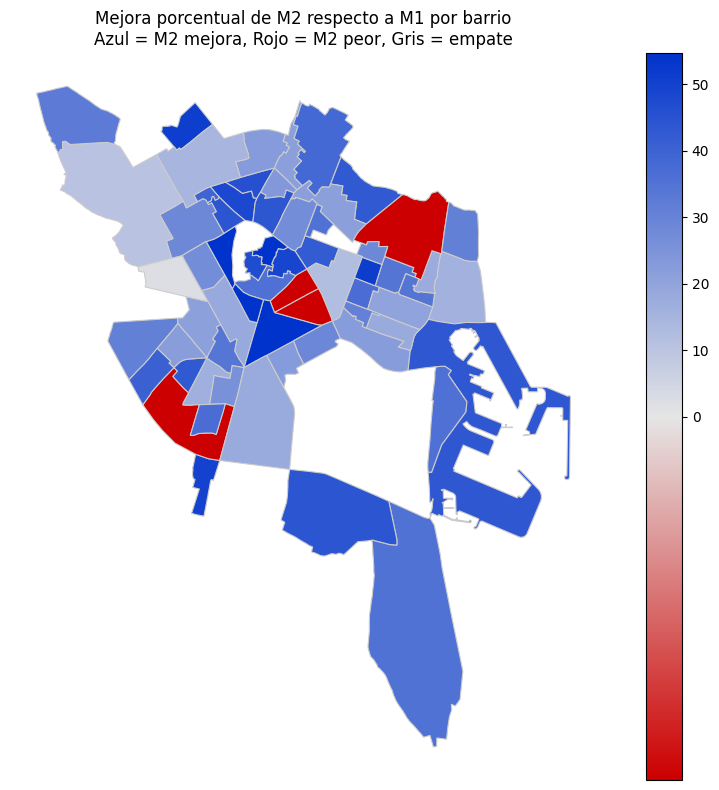

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# Cargar los datos
df = pd.read_csv('../../data/output/results_simulations.csv')


# Calcular el costo medio por modelo y barrio
mean_cost = df.groupby(['barrio', 'modelo'])['total_cost'].mean().unstack()

# Calcular la mejora porcentual de M2 respecto a M1
mean_cost['diff_pct'] = ((mean_cost['M1'] - mean_cost['M2']) / mean_cost['M1']) * 100

# Cargar el mapa de barrios
gdf = gpd.read_file('../../data/input/barris.geojson')

# Unir con los datos
gdf = gdf.merge(mean_cost[['diff_pct']], how='left', left_on='nombre', right_on='barrio')

# Crear colormap centrado en 0: rojo (M2 peor), gris (empate), azul (M2 mejor)
colors = [(0.8, 0.0, 0.0), (0.9, 0.9, 0.9), (0.0, 0.2, 0.8)]  # rojo - gris - azul
cmap = LinearSegmentedColormap.from_list("m2_mejora", colors)

# Normalización con percentiles y centro en 0
vmin = mean_cost['diff_pct'].quantile(0.05)
vmax = mean_cost['diff_pct'].quantile(0.95)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Graficar
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='diff_pct', cmap=cmap, linewidth=0.8, edgecolor='0.8',
         legend=True, ax=ax, norm=norm)

ax.set_title('Mejora porcentual de M2 respecto a M1 por barrio\nAzul = M2 mejora, Rojo = M2 peor, Gris = empate')
plt.axis('off')
plt.tight_layout()
plt.show()




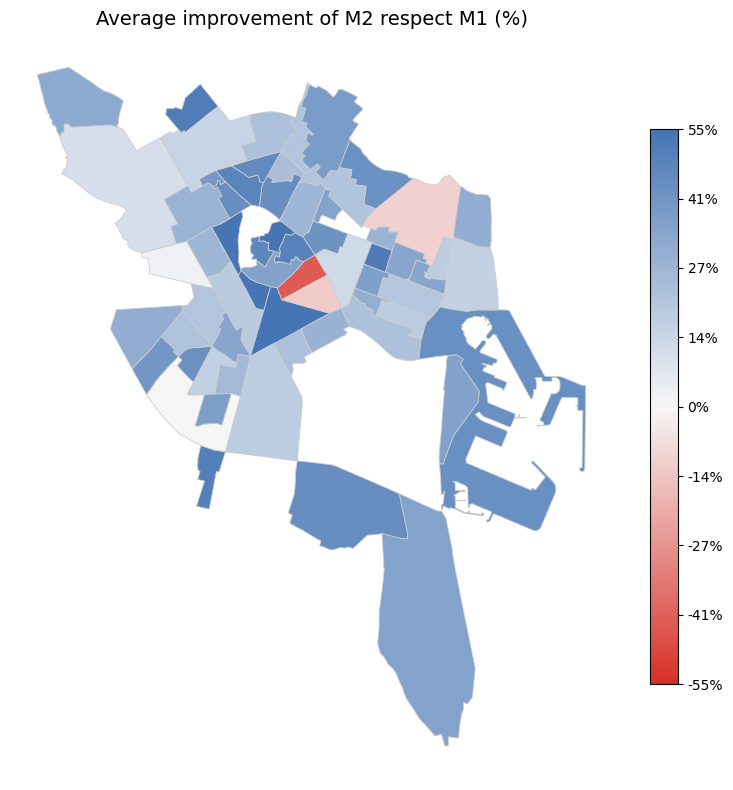

In [1]:
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Cargar los datos
df = pd.read_csv('../../data/output/results_simulations.csv')


# Calcular el costo medio por modelo y barrio
mean_cost = df.groupby(['barrio', 'modelo'])['total_cost'].mean().unstack()

# Calcular la mejora porcentual de M2 respecto a M1
mean_cost['diff_pct'] = ((mean_cost['M1'] - mean_cost['M2']) / mean_cost['M1']) * 100

# Cargar el mapa de barrios
gdf = gpd.read_file('../../data/input/barris.geojson')

# Unir con los datos
gdf = gdf.merge(mean_cost[['diff_pct']], how='left', left_on='nombre', right_on='barrio')
# 1) Crisper palette: pure red – white – pure blue
colors = ["#d73027", "#f7f7f7", "#4575b4"]
cmap = LinearSegmentedColormap.from_list("m2_improvement", colors)

# 2) Symmetric normalization around zero, using the maximum absolute value of the percentiles
p05, p95 = mean_cost['diff_pct'].quantile([0.05, 0.95])
lim = max(abs(p05), abs(p95))
norm = TwoSlopeNorm(vmin=-lim, vcenter=0, vmax=lim)

# 3) Create the map without an automatic legend
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged = gdf.plot(
    column='diff_pct',
    cmap=cmap,
    norm=norm,
    linewidth=0.6,
    edgecolor='0.8',
    legend=False,
    ax=ax
)

# 4) Add colorbar manually with ticks and percentage formatting
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # hack to make the colorbar work
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
ticks = np.linspace(-lim, lim, 9)  # 9 intervals
cbar.set_ticks(ticks)
cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

# 5) Title and final adjustments
ax.set_title(
    'Average improvement of M2 respect M1 (%)',
    fontsize=14
)
ax.axis('off')
plt.tight_layout()
plt.show()


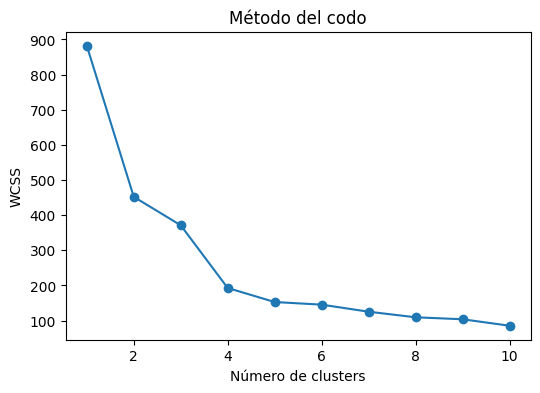

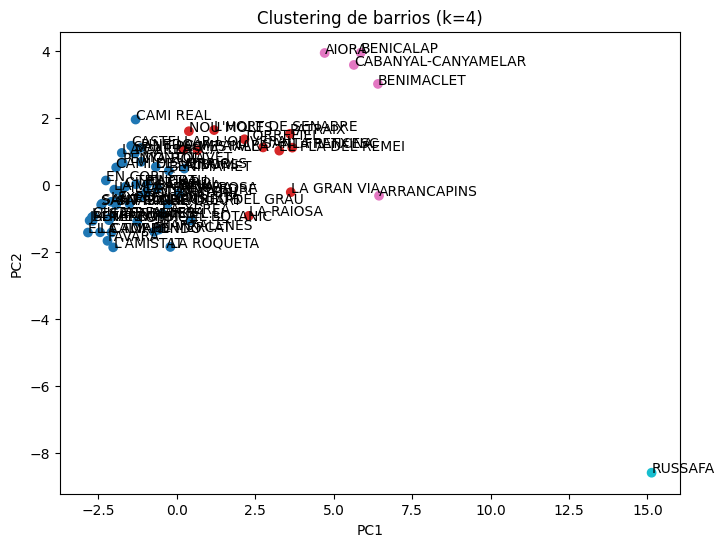

               cluster
barrio                
AIORA                2
ALBORS               0
ARRANCAPINS          2
BENICALAP            2
BENIMACLET           2
...                ...
SANT PAU             0
TORMOS               0
TORREFIEL            1
TRINITAT             0
VARA DE QUART        0

[63 rows x 1 columns]


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Cargar datos
df = pd.read_csv('../../data/output/results_simulations.csv')
numeric_cols = df.select_dtypes(include=[np.number]).columns
barrio_feats = df.groupby('barrio')[numeric_cols].mean()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(barrio_feats)

# Determinar número de clusters (opcional: método del codo)
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss, 'o-')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del codo')
plt.show()

# Aplicar KMeans (e.g. k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
barrio_feats['cluster'] = labels

# Visualización vía PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(pcs[:,0], pcs[:,1], c=labels, cmap='tab10')
for i, barrio in enumerate(barrio_feats.index):
    plt.text(pcs[i,0], pcs[i,1], barrio)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering de barrios (k=4)')
plt.show()

# Resultado final con etiqueta de cluster por barrio
print(barrio_feats[['cluster']])









In [17]:
gdf

,coddistbar,nombre,coddistrit,codbarrio,gis_gis_barrios_area,geo_point_2d,geometry
0,092,L'HORT DE SENABRE,9,2,4.263543e+06,"{ ""lon"": -0.39080554312920629, ""lat"": 39.45150...","POLYGON ((-0.39032 39.45643, -0.38863 39.45552..."
1,132,CIUTAT JARDI,13,2,NaN,"{ ""lon"": -0.34504270296154638, ""lat"": 39.47198...","POLYGON ((-0.34709 39.47548, -0.34144 39.47379..."
2,142,CAMI DE VERA,14,2,NaN,"{ ""lon"": -0.35238807559570928, ""lat"": 39.48736...","POLYGON ((-0.35156 39.48155, -0.35442 39.48244..."
3,083,VARA DE QUART,8,3,NaN,"{ ""lon"": -0.4068974612878839, ""lat"": 39.459541...","POLYGON ((-0.41435 39.45959, -0.41434 39.45963..."
4,031,EL BOTANIC,3,1,3.701156e+06,"{ ""lon"": -0.38596793151401049, ""lat"": 39.47613...","POLYGON ((-0.38302 39.48028, -0.38373 39.47834..."
...,...,...,...,...,...,...,...
58,033,LA PETXINA,3,3,4.966688e+06,"{ ""lon"": -0.39098170775459257, ""lat"": 39.47356...","POLYGON ((-0.39047 39.47825, -0.38996 39.47754..."
59,094,SANT MARCEL.LI,9,4,3.304382e+06,"{ ""lon"": -0.39002522601363038, ""lat"": 39.44497...","POLYGON ((-0.38582 39.44784, -0.38631 39.4464,..."
60,193,PINEDO,19,3,NaN,"{ ""lon"": -0.33967854582733203, ""lat"": 39.40629...","POLYGON ((-0.35018 39.42223, -0.35011 39.42227..."
61,192,CASTELLAR-L'OLIVERAL,19,2,NaN,"{ ""lon"": -0.35925852533068098, ""lat"": 39.42715...","POLYGON ((-0.37229 39.42602, -0.37229 39.42602..."


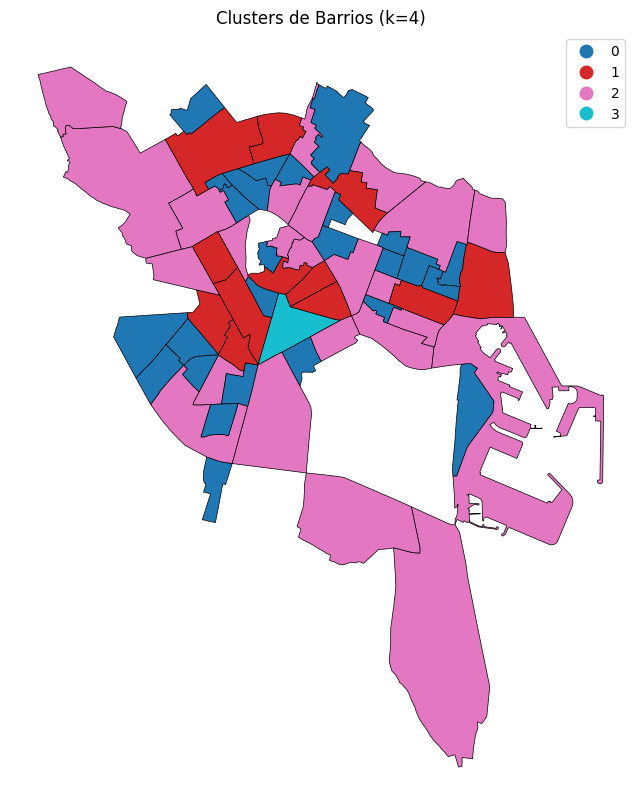

In [19]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Carga de datos de simulaciones
df = pd.read_csv('../../data/output/results_simulations.csv')

# 2. Agrupar por barrio y calcular medias de variables numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
barrio_stats = df.groupby('barrio')[numeric_cols].mean().reset_index()

# 3. Carga del GeoJSON de barrios
#    Ajusta la ruta al archivo GeoJSON con tus límites de barrio
gdf = gpd.read_file('../../data/input/barris.geojson')
gdf['barrio'] = gdf['nombre']
# 4. Unión de estadísticas con geometrías
gdf = gdf.merge(barrio_stats, on='barrio', how='left')

# 5. Escalado de variables y K-Means (k=4)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gdf[numeric_cols])
kmeans = KMeans(n_clusters=4, random_state=42)
gdf['cluster'] = kmeans.fit_predict(X_scaled)

# 6. Pintar los 4 clusters en un mapa
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='cluster',
         categorical=True,
         legend=True,
         ax=ax,
         edgecolor='black',
         linewidth=0.5)
ax.axis('off')
plt.title('Clusters de Barrios (k=4)')
plt.show()
